In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Part One: EDA

In [2]:
# import login counts json to pandas df
df = pd.read_json("logins.json")
df.index=df['login_time']
df.rename(columns={'login_time':'log_in'}, inplace=True)
df.head()

,log_in
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


In [3]:
# aggregate login counts based on 15-minute time intervals
agg_15 = df.groupby(pd.Grouper(freq='15Min')).size()
agg_15.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, dtype: int64

In [4]:
# data cleaning checks
agg_15.describe()
# this one 15 min period with 73 logins may be an outlier, but also seems plausible to me

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
dtype: float64

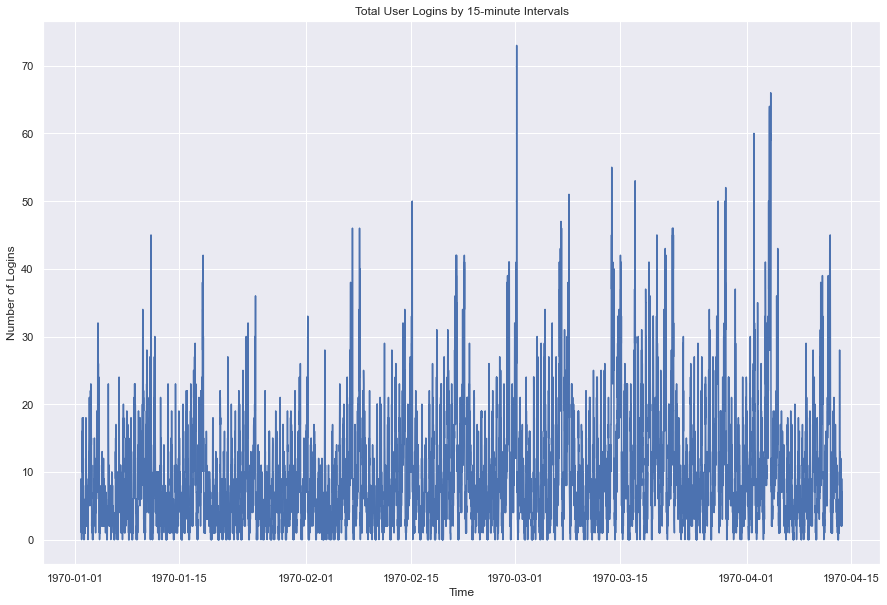

In [5]:
# plot time series of login counts
sns.set_theme(style='darkgrid')
_ = plt.figure(figsize=(15,10))
_ = plt.title("Total User Logins by 15-minute Intervals")
_ = plt.ylabel("Number of Logins")
_ = plt.xlabel("Time")
_ = sns.lineplot(data=agg_15)

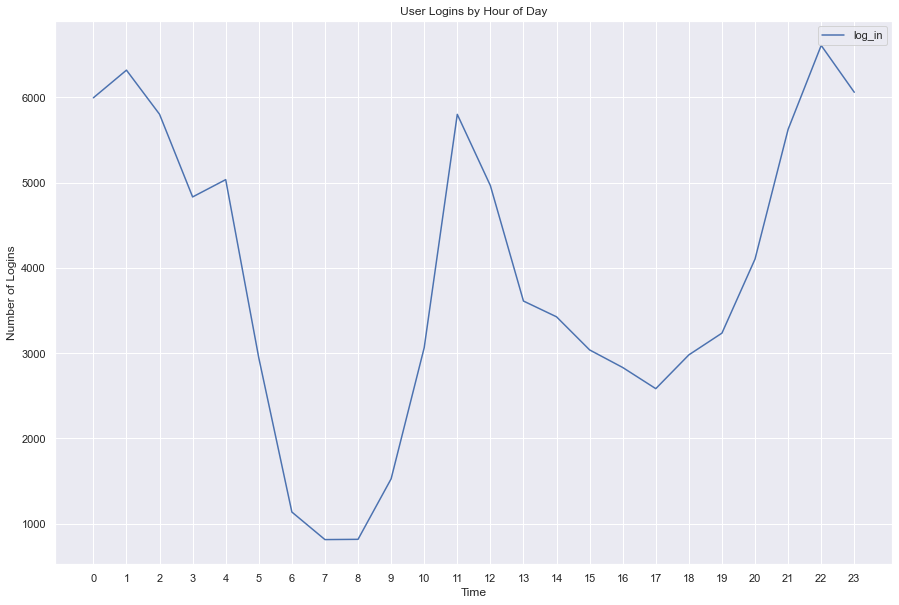

In [6]:
# plot time series of login counts (daily)
df['hour'] = df['log_in'].dt.hour
agg_hour = df.groupby('hour').count()

_ = plt.figure(figsize=(15,10))
_ = plt.title("User Logins by Hour of Day")
_ = plt.ylabel("Number of Logins")
_ = plt.xlabel("Time")
x_ticks = np.arange(24)
_ = plt.xticks(x_ticks)
_ = sns.lineplot(data=agg_hour)

So in terms of user patterns, we have usage peaks in the 1a-2a, 11a-12p, and 10-11p (2200-2300) hours. Our biggest user login dip is from 0600-0900.

## Part Two: Experiement and Metrics Design

1. What would you choose as the key measure of success of the toll reimbursement experiment, and why would you choose this metric?

There are a several factors we want to look at when introducing this toll reimbursement experiment. The whole point of toll reimbursement is to improve service reliability, as in making sure we have enough drivers a short distance from passengers on each side of the bridge. We don't want passengers ordering a ride, seeing the wait time is long, and seeking an alternative. So checking the average passenger wait time for a driver to arrive would be of interest.

But ultimately, increasing the service reliability is a means to an end: __profitiablity__. If paying for drivers to cross the bridge is costing Ultimate more than the value added by having drivers more readily available on each side of the bridge, then it's probably not worthwhile. But this projection for profitablity shouldn't just account for an individual day's overall earnings--you should also include as part of the long-term profitability a prediction of user churn for unreliable service.

2. Design a practical experiment to compare the effectiveness of the toll reimbursement experiment.

__Experiment Proposal__

__Experiment Implementation Steps__

a) Email a specific subset of drivers (preferably highly-rated, which I am assuming is a proxy for reliablility) telling them their tolls will be reimbursed for each weekend in an upcoming month (preferably a month which we believe is representative of business trends).

b) Check to see what percentage of those drivers offered are taking advantage of the offer

c) Measure the change in relative reliability of the network overall, as measured by average pickup time

d) Measure the change in relative profitability of the network overall, including the cost of toll reimbursement, the number of trips, the total value of trips

e) Using previous data, compare the loss in tolls reimbursed to the value added in both income for the night (due to more trips being given more quickly) and increased service reliability (reduced user churn)

__Statistical Tests to Verify Significance of Observation__

Check that this was not just a result of random chance, by checking the p-value of the reduced wait time over the four test weekends. Also check the p-value for the number of rides given each weekend night, and the average trip cost.

__How to Interpret the Results__

Again, these measures of average pickup time, number of trips given, and value of each trip are means to an end: profitability. So, if the p-value of average pickup time is low, then the toll reimbursement has likely been effective in increasing service reliability. But that result should then be translated to its net change in profitability to see if it is worthwhile.

Similarly, a low p-value for number of trips given would indicate that reimbursing tolls decreased wait time and meant less passenger cancellations, so more trips. But whether that lead to more profitability would be a matter of it compared to weekends where the program was not in effect.

If the average trip cost p-value was low, this would also be of interest, and should be intepreted in terms of profitability in the context of the other two p-values.

__Subsequent Recommendations to the City Operations Team__
If the program was net profitable with our small test subset of drivers, I would recommend a gradual rollout to lower rated drivers, with repeated checks on net profitability based on service reliability.

__Caveats to Recommendations__
I would continue to offer the program to drivers on a month-to-month provisional basis, in case there were unforeseen consequences in months with particularly different business patterns.

## Part Three: Predictive Modeling
Build a predictive model for user retention (active users defined as having taken a trip in the last 30 days).

In [7]:
# import json as pandas df
df = pd.read_json("ultimate_data_challenge.json")
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [8]:
# find nas
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent'])
pos = nas['percent'] > 0
nas[pos]

,percent
avg_rating_of_driver,0.16244
phone,0.00792
avg_rating_by_driver,0.00402


In [9]:
# determine appropriate replacement values for nas
driver_avg = df['avg_rating_of_driver'].sum()/len(df['avg_rating_of_driver'])
passenger_avg = df['avg_rating_by_driver'].sum()/len(df['avg_rating_by_driver'])
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [10]:
# replace nas
df['avg_rating_of_driver'].fillna(value=driver_avg, inplace=True)
df['phone'].fillna(value='iPhone', inplace=True)
df['avg_rating_by_driver'].fillna(value=passenger_avg, inplace=True)

In [11]:
# convert str dates to dt
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [12]:
# add column for our response variable, drop other cols
df['retained'] = df['last_trip_date'] >= '2014-06-01 00:00:00'
df.drop(columns=['last_trip_date','signup_date'],inplace=True)

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,50000.0,4.480139,0.628662,1.0,4.00,4.70,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,50000.0,4.778081,0.445755,1.0,4.70,5.00,5.00,5.00


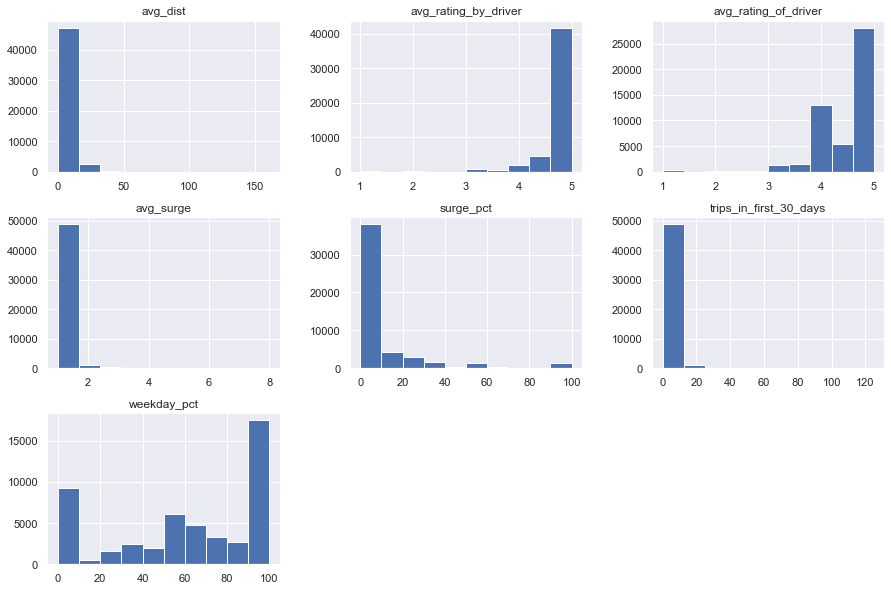

In [14]:
# plot histograms of numerical variables
num_cols = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct','avg_dist','avg_rating_by_driver']
_ = df[num_cols].hist(bins=10, figsize=(15,10))

In [15]:
# check in on some outliers
df.loc[df['trips_in_first_30_days']>100]
# this one seems to be valid data, although this user took a *lot* of trip in their first 30 days

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
18514,King's Landing,125,5.0,1.12,iPhone,14.4,True,72.0,2.02,4.8,True


In [16]:
# check in on some outliers
df.loc[df['avg_surge']>4]
# these appear to be valid data points--users who signed up, took a high surge trip or two, and then churned

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
1405,Winterfell,1,5.000000,4.75,iPhone,100.0,False,100.0,6.46,5.0,False
2817,Winterfell,0,5.000000,5.00,iPhone,100.0,False,100.0,3.18,5.0,False
5355,Winterfell,1,5.000000,4.25,Android,100.0,False,100.0,0.69,5.0,False
10546,Winterfell,0,3.854082,4.50,iPhone,100.0,False,0.0,2.70,5.0,True
13861,Winterfell,1,1.000000,8.00,iPhone,100.0,False,100.0,5.77,5.0,False
15334,Winterfell,0,3.854082,4.50,iPhone,100.0,False,100.0,1.40,5.0,True
19191,Winterfell,1,5.000000,5.00,Android,100.0,False,100.0,3.37,5.0,False
21742,Winterfell,0,3.854082,4.50,iPhone,100.0,False,0.0,1.42,5.0,True
21894,Winterfell,1,3.854082,5.00,Android,100.0,False,100.0,2.46,4.0,False
25397,Winterfell,0,3.854082,4.25,Android,100.0,False,0.0,3.22,5.0,True


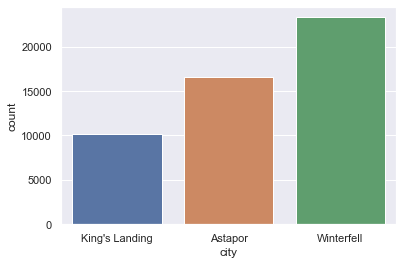

In [17]:
# Categorical Histograms
_ = sns.countplot(data=df, x='city')

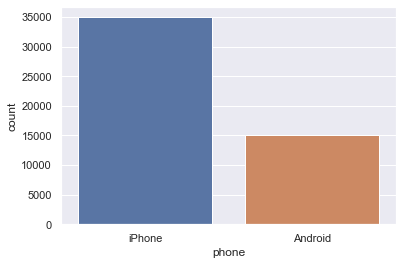

In [18]:
_ = sns.countplot(data=df, x='phone')

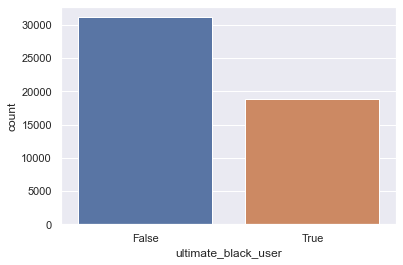

In [19]:
_ = sns.countplot(data=df, x='ultimate_black_user')

In [20]:
# the percentage of observed users who used Ultimate Black in first month
round(df['ultimate_black_user'].mean() * 100,1)

37.7

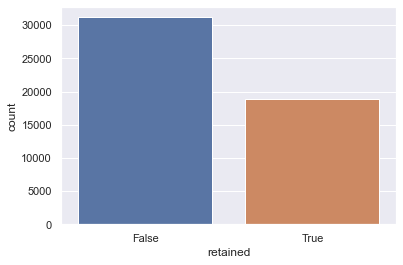

In [21]:
_ = sns.countplot(data=df, x='retained')

In [22]:
# the percentage of observed users who were retained
round(df['retained'].mean() * 100,1)

37.6

In [23]:
# one hot encode categorical variables, drop former labels
df = pd.get_dummies(df,drop_first=True)

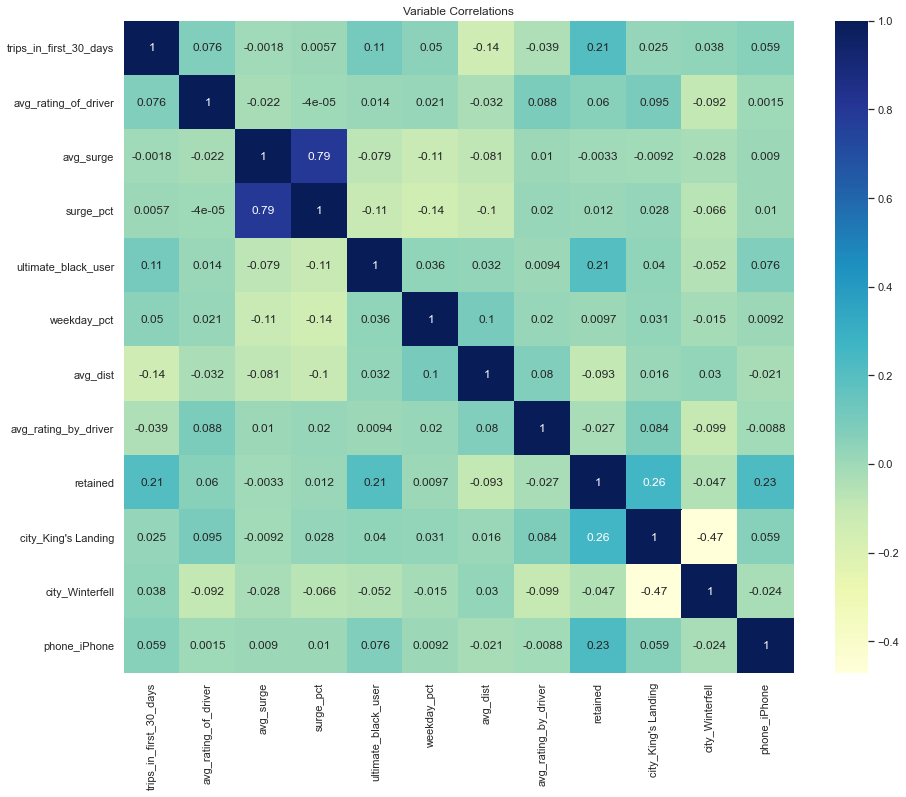

In [24]:
# correlation matrix heatmap
_ = plt.figure(figsize=(15,12))
_ = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
_ = plt.title("Variable Correlations")
plt.show()

In [25]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(["retained"], axis=1)
y = df['retained']
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
def classifier_suite(X_train,y_train):
    '''Runs through many untuned ensemble classifiers, returns performance metrics as a pd df'''
    from sklearn.svm import LinearSVC, SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
    import pandas as pd
    import warnings
    warnings.simplefilter('ignore')
    classifiers = [LinearSVC(),SVC(),KNeighborsClassifier(),
                   RandomForestClassifier(),AdaBoostClassifier(),
                   GradientBoostingClassifier(),XGBClassifier()]
    metrics = [roc_auc_score,accuracy_score,f1_score]
    performance = {}
    for clf in classifiers:
        y_pred = clf.fit(X_train,y_train).predict(X_test)
        scores = []
        for metric in metrics:
            scores.append(metric(y_test,y_pred))
        performance[clf] = scores
    
    df = pd.DataFrame(performance,index=["AUROC","Accuracy","F1"])
    df.columns = ['LinearSVC','SVC','KNeighborsClassifier',
              'RandomForestClassifier','AdaBoostClassifier',
              'GradientBoostingClassifier','XGBClassifier']
    return df.T

In [27]:
initial_performance = classifier_suite(X_train,y_train)
initial_performance

,AUROC,Accuracy,F1
LinearSVC,0.669757,0.71896,0.558058
SVC,0.734321,0.76960,0.658687
KNeighborsClassifier,0.720780,0.74432,0.647396
RandomForestClassifier,0.736491,0.75624,0.668912
AdaBoostClassifier,0.753647,0.78056,0.688047
GradientBoostingClassifier,0.762214,0.78768,0.699706
XGBClassifier,0.762844,0.78664,0.700975


So of the above models, out of the box, __XG Boost__ performs nearly the best for all three of our performance metrics. So that would be my initial choice for which model to use to predict user retention. With tuning, you could expect some performance improvement beyond these initial scores.

The model takes inputs of our predictor variables (city, phone, avg_dist, avg_rating_by_driver, avg_rating_of_driver, surge_pct, avg_surge, trips_in_first_30_days, ultimate_black_user, and weekday_pct) to predict the probability of a user remaining active in their sixth month.

It accurately predicts a user behavior just over 79% of the time.

The model can be broken down by feature importance, to show how much each of the input variables influences the eventual behavior of a user.

In [28]:
# pull features from XGB
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
features = xgb.feature_importances_

In [29]:
feature_importance = pd.DataFrame(zip(df.drop(columns='retained').columns,features))

In [30]:
feature_importance

,0,1
0,trips_in_first_30_days,0.034077
1,avg_rating_of_driver,0.022048
2,avg_surge,0.023923
3,surge_pct,0.088022
4,ultimate_black_user,0.092449
5,weekday_pct,0.049782
6,avg_dist,0.017640
7,avg_rating_by_driver,0.177467
8,city_King's Landing,0.297473
9,city_Winterfell,0.037110


So, from above, we can conclude that what city a user is from seems to matter a lot, as does their phone. So perhaps our Android app needs updating. Ultimate_black_user is also an important feature, so maybe we could offer an Ultimate_Black discount to users in their first month in order to increase user retention.

A predictive model like this could also be used to project which customers might need more incentives to stay active (and which might not need any extra push expended). These are just some of the initial potential value adds for a model like this.